# MCMC sampling diagnostics

In this notebook, we illustrate how to assess the quality of your MCMC samples, e.g. convergence and auto-correlation, in pyPESTO.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function for analytical_a (obs_a)
def analytical_a(t, a0, b0, k1=0.8, k2=0.6):
    return k2 * (a0 + b0) / (k1 + k2) + (
        k2 * (a0 + b0) / (k1 + k2)
    ) * np.exp((-k1 - k2) * t)
    
# def analytical_a(t, a0, b0, k1=0.8, k2=0.6):
#     return k2 * (a0 + b0) / (k1 + k2) + (
#         np.abs(k1*a0 - k2*b0) / (k1 + k2)
#     ) * np.exp(-(k1 + k2)*t)

k1_true = 0.5
k2_true = 0.05

def analytical_a(t, a0, b0, k1=0.5, k2=0.05):
    alpha = k1 + k2
    beta = k2 * (a0 + b0)
    
    return beta / alpha + np.abs(alpha*a0 - beta)/alpha * np.exp(-alpha*t)


# conditions = [(1.25, 0.25), (1.5, 0.3), (1.75, 0.35)]  # Example conditions
conditions = [(2.0, 0.0), (1.5, 0.5), (1.0, 1.0), (0.5, 1.5)]
num_conditions = len(conditions)
times = np.linspace(0, 3, 10)
sigma = 0.02

# Initialize an empty dataframe
measurement_df = pd.DataFrame(columns=['observableId', 'simulationConditionId', 'time', 'measurement'])

conditions_data = []

for i, (a0, b0) in enumerate(conditions, start=1):
    measurements_a = [analytical_a(t, a0, b0, k1_true, k2_true) for t in times] + sigma * np.random.randn(len(times))
    measurements_b = a0 + b0 - measurements_a

    # Create dataframes for obs_a and obs_b
    df_a = pd.DataFrame({
        'observableId': ['obs_a'] * len(times),
        'simulationConditionId': [f'c_{i}'] * len(times),
        'time': times,
        'measurement': measurements_a
    })

    df_b = pd.DataFrame({
        'observableId': ['obs_b'] * len(times),
        'simulationConditionId': [f'c_{i}'] * len(times),
        'time': times,
        'measurement': measurements_b
    })

    # Append to the main dataframe
    measurement_df = pd.concat([measurement_df, df_a, df_b], ignore_index=True)
    # measurement_df = pd.concat([measurement_df, df_a], ignore_index=True)
    
    # Add to conditions data
    # conditions_data.append({'conditionId': f'c_{i}', 'a0': a0, 'b0': b0})
    conditions_data.append({
                            'conditionId': f'c_{i}', 
                            'conditionName': f'c_{i}',
                            'A': a0,
                            'B': b0})

# Convert conditions data to dataframe
conditions_df = pd.DataFrame(conditions_data)

# Save the dataframe to a file
measurement_df.to_csv('doc/example/TEST_conversion_reaction/multiple_conditions/measurements.tsv', sep='\t', index=False)

conditions_df.to_csv('doc/example/TEST_conversion_reaction/multiple_conditions/conditions.tsv', sep='\t', index=False)

/tmp/ipykernel_904/1790921193.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  measurement_df = pd.concat([measurement_df, df_a, df_b], ignore_index=True)


## The pipeline

First, we load the model and data to generate the MCMC samples from. Here, we show a toy example of a conversion reaction, loaded as a [PEtab](https://github.com/petab-dev/petab) problem.

In [4]:
import logging

import numpy as np
import petab
import amici
import amici.plotting
import sys
import os
import importlib

import pypesto
import pypesto.optimize as optimize
import pypesto.petab
import pypesto.sample as sample
import pypesto.visualize as visualize

# log diagnostics
logger = logging.getLogger("pypesto.sample.diagnostics")
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

# import to petab
petab_problem = petab.Problem.from_yaml(
    "doc/example/TEST_conversion_reaction/multiple_conditions/conversion_reaction.yaml",
)
# petab_problem = petab.Problem.from_yaml(
#     "doc/example/conversion_reaction/conversion_reaction.yaml"
# )
# import to pypesto
importer = pypesto.petab.PetabImporter(petab_problem)
# create problem
problem = importer.create_problem()

Visualization table not available. Skipping.


Create the sampler object, in this case we will use adaptive parallel tempering with 3 temperatures.

In [3]:
sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=3,
)

Initializing betas with "near-exponential decay".


First, we will initiate the MCMC chain at a "random" point in parameter space, e.g. $\theta_{start} = [3, -4]$

In [5]:
%%capture
n_samples = 10000
result = sample.sample(
    problem,
    n_samples=n_samples,
    sampler=sampler,
    x0=np.array([10, 10]),
    filename=None,
)
elapsed_time = result.sample_result.time
print(f"Elapsed time: {round(elapsed_time,2)}")

Elapsed time: 17.789673682


/PyPESTO/pypesto/visualize/sampling.py:1117: UserWarning: Burn in index not found in the results, the full chain will be shown.
You may want to use, e.g., `pypesto.sample.geweke_test`.
  nr_params, params_fval, theta_lb, theta_ub, param_names = get_data_to_plot(


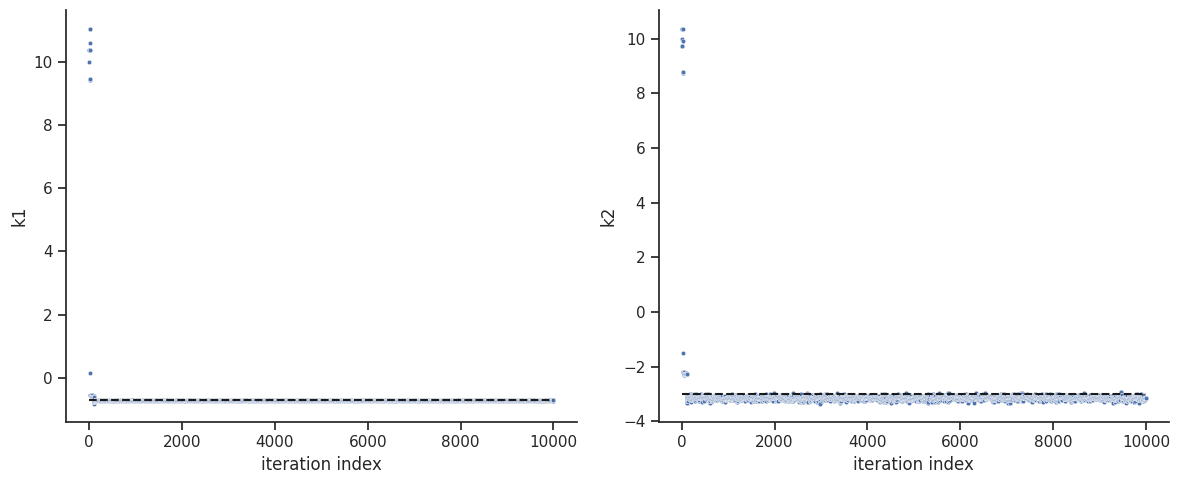

In [6]:
ax = visualize.sampling_parameter_traces(
    result, use_problem_bounds=False, size=(12, 5)
)
ax[0][0].plot([0, n_samples], np.log([k1_true, k1_true]), "k--")
ax[0][1].plot([0, n_samples], np.log([k2_true, k2_true]), "k--")
# ax[0][0].set_ylim([0, 2])
# ax[0][1].set_ylim([0, 0.1])

By visualizing the chains, we can see a warm up phase occurring until convergence of the chain is reached. This is commonly known as "burn in" phase and should be discarded. An automatic way to evaluate and find the index of the chain in which the warm up is finished can be done by using the Geweke test.

Geweke burn-in index: 500
Geweke burn-in index: 500


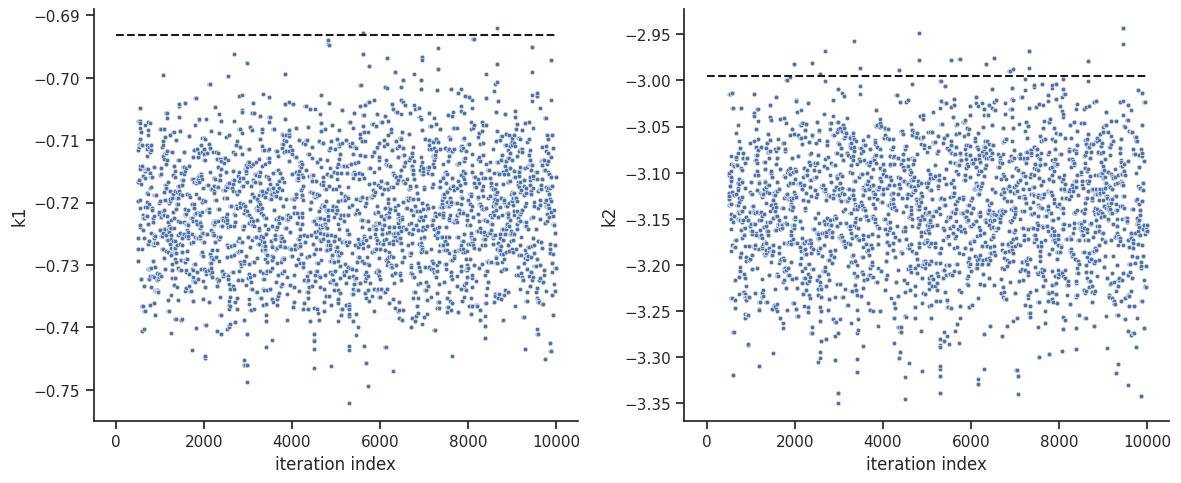

In [7]:
sample.geweke_test(result=result)
ax = visualize.sampling_parameter_traces(
    result, use_problem_bounds=False, size=(12, 5)
)
ax[0][0].plot([0, n_samples], np.log([k1_true, k1_true]), "k--")
ax[0][1].plot([0, n_samples], np.log([k2_true, k2_true]), "k--")

(-0.1, 2.0)

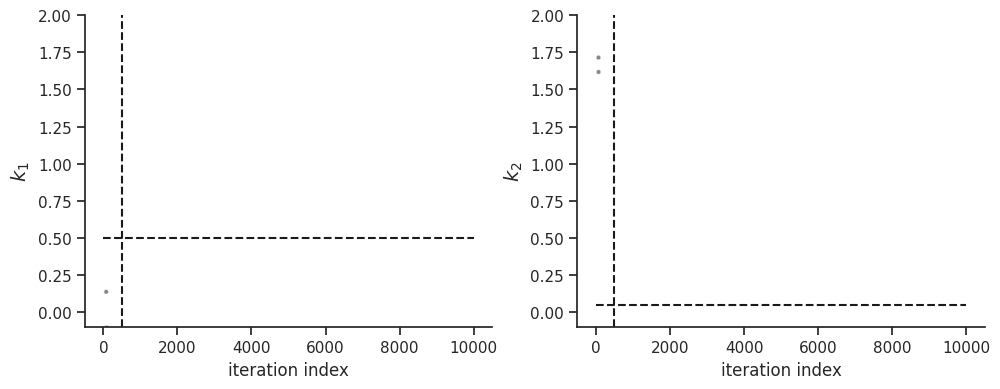

In [9]:
ax = visualize.sampling_parameter_traces(
    result, use_problem_bounds=False, full_trace=True, size=(10, 4)
)
ax[0][0].plot([0, n_samples], ([k1_true, k1_true]), "k--")
ax[0][1].plot([0, n_samples], ([k2_true, k2_true]), "k--")

ax[0][0].set_ylabel('$k_1$', fontsize=14)
ax[0][1].set_ylabel('$k_2$', fontsize=14)
ax[0][0].set_xlabel('iteration index', fontsize=12)
ax[0][1].set_xlabel('iteration index', fontsize=12)

ax[0][0].set_ylim([-0.1, 2])
ax[0][1].set_ylim([-0.1, 2])

Axes(0.11582,0.145312;0.377637x0.737603)
Axes(0.138281,0.145312;0.347559x0.740104)
Axes(0.138477,0.145312;0.347461x0.740104)


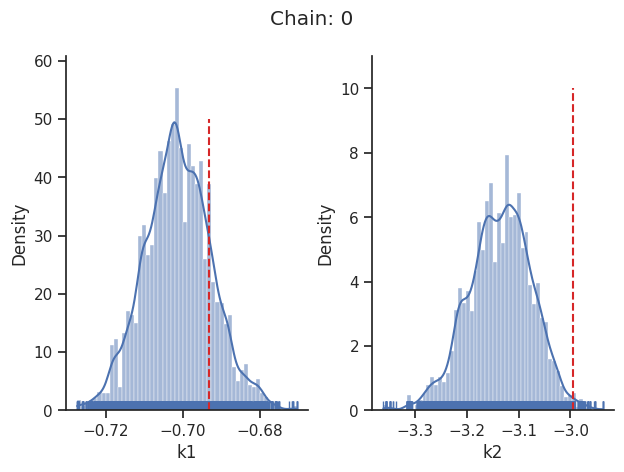

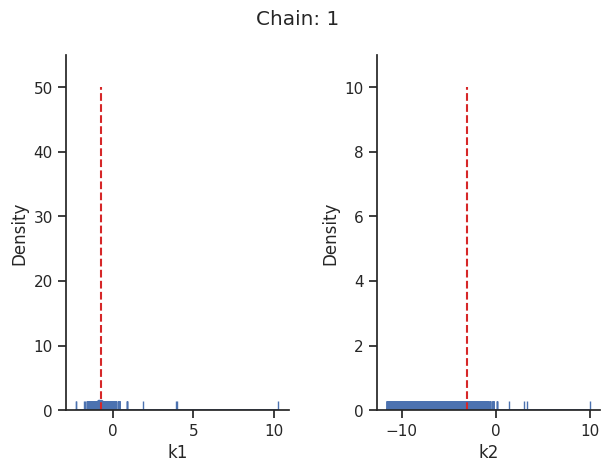

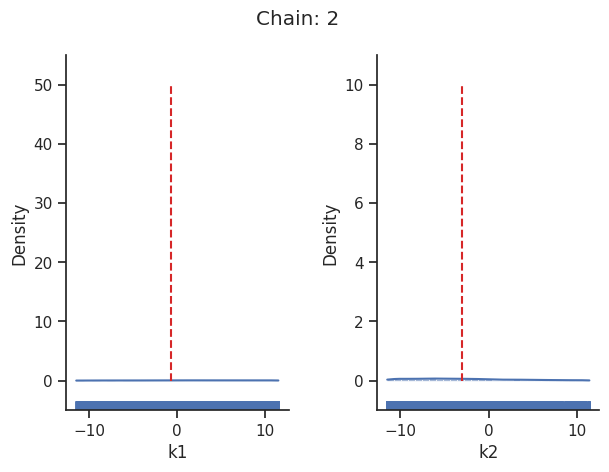

In [10]:
for i_chain in range(len(result.sample_result.betas)):
    ax = visualize.sampling_1d_marginals(
        result, i_chain=i_chain, suptitle=f"Chain: {i_chain}"
    )
    ax = ax[0]
    print(ax[0])
    ax[0].vlines(np.log(k1_true), 0, 50, color="tab:red", linestyle="--")
    ax[1].vlines(np.log(k2_true), 0, 10, color="tab:red", linestyle="--")

One can calculate the effective sample size per computation time. We save the results in a variable to compare them later.

In [11]:
sample.effective_sample_size(result=result)
ess = result.sample_result.effective_sample_size
print(
    f"Effective sample size per computation time: {round(ess/elapsed_time,2)}"
)

Estimated chain autocorrelation: 8.19013697966099
Estimated chain autocorrelation: 8.19013697966099
Estimated effective sample size: 1033.8257221874921
Estimated effective sample size: 1033.8257221874921


Effective sample size per computation time: 63.58


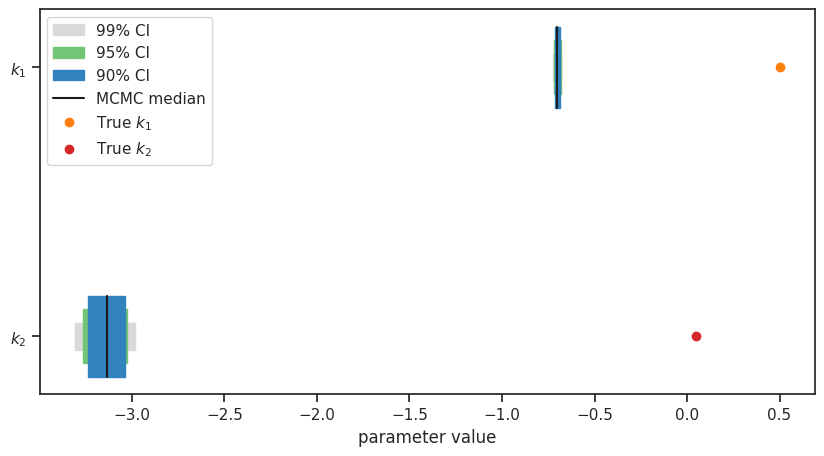

In [13]:
alpha = [99, 95, 90]
ax = visualize.sampling_parameter_cis(result, alpha=alpha, size=(10, 5))
line1, = ax.plot([(k1_true)], 0, 'o', color='tab:orange', label='True $k_1$')
line2, = ax.plot([(k2_true)], 1, 'o', color='tab:red', label='True $k_2$')
# ax.legend()
# Get existing legend handles and labels
handles, labels = ax.get_legend_handles_labels()

unique_handles_labels = list(dict(zip(labels, handles)).items())
unique_labels, unique_handles = zip(*unique_handles_labels)

# Update the legend with unique handles and labels
ax.legend(unique_handles, unique_labels)
ax.set_yticks([0,1],['$k_1$', '$k_2$'])
ax.set_xlabel('parameter value')
ax.set_ylabel('')
plt.show()
# ax.vlines(np.log([k1_true, k2_true]), 0, 1, color="k", linestyle="--")

Predictions can be performed by creating a parameter ensemble from the sample, then applying a predictor to the ensemble. The predictor requires a simulation tool. Here, [AMICI](https://github.com/AMICI-dev/AMICI) is used. First, the predictor is set up.

In [52]:
from pypesto.C import AMICI_STATUS, AMICI_T, AMICI_X, AMICI_Y
from pypesto.predict import AmiciPredictor


# This post_processor will transform the output of the simulation tool
# such that the output is compatible with the next steps.
def post_processor(amici_outputs, output_type, output_ids):
    outputs = [
        (
            amici_output[output_type]
            if amici_output[AMICI_STATUS] == 0
            else np.full((len(amici_output[AMICI_T]), len(output_ids)), np.nan)
        )
        for amici_output in amici_outputs
    ]
    return outputs


# Setup post-processors for both states and observables.
from functools import partial

amici_objective = result.problem.objective
state_ids = amici_objective.amici_model.getStateIds()
observable_ids = amici_objective.amici_model.getObservableIds()
post_processor_x = partial(
    post_processor,
    output_type=AMICI_X,
    output_ids=state_ids,
)
post_processor_y = partial(
    post_processor,
    output_type=AMICI_Y,
    output_ids=observable_ids,
)

# Create pyPESTO predictors for states and observables
predictor_x = AmiciPredictor(
    amici_objective,
    post_processor=post_processor_x,
    output_ids=state_ids,
)
predictor_y = AmiciPredictor(
    amici_objective,
    post_processor=post_processor_y,
    output_ids=observable_ids,
)

In [53]:
predictor_x.amici_objective.amici_object_builder

Next, the ensemble is created.

In [54]:
from pypesto.C import EnsembleType
from pypesto.ensemble import Ensemble

# corresponds to only the estimated parameters
x_names = result.problem.get_reduced_vector(result.problem.x_names)

# Create the ensemble with the MCMC chain from parallel tempering with the real temperature.
ensemble = Ensemble.from_sample(
    result,
    chain_slice=slice(
        None, None, 5
    ),  # Optional argument: only use every fifth vector in the chain.
    x_names=x_names,
    ensemble_type=EnsembleType.sample,
    lower_bound=result.problem.lb,
    upper_bound=result.problem.ub,
)

The predictor is then applied to the ensemble to generate predictions.

In [55]:
from pypesto.engine import MultiProcessEngine

engine = MultiProcessEngine()

ensemble_prediction = ensemble.predict(
    predictor_x, prediction_id=AMICI_X, engine=engine
)

Engine will use up to 8 processes (= CPU count).
 ... (more hidden) ...


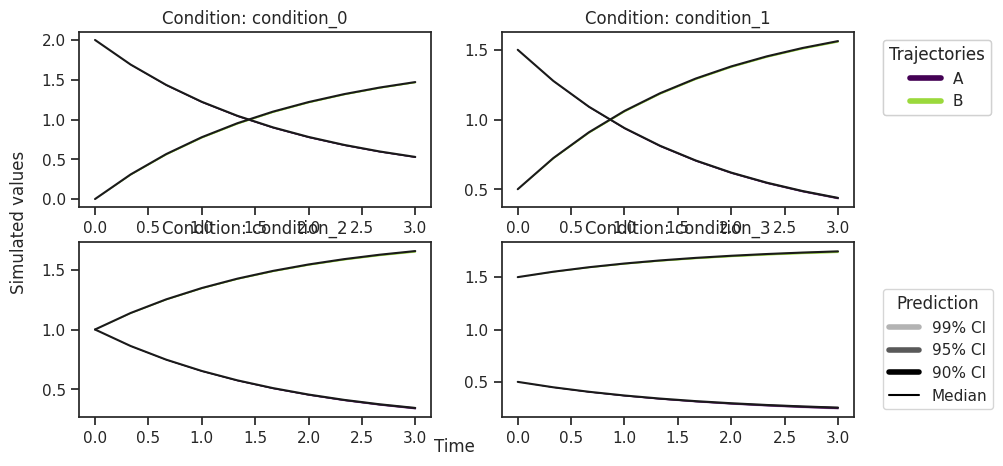

In [56]:
from pypesto.C import CONDITION, OUTPUT

credibility_interval_levels = [90, 95, 99]

ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(10, 5),
    # labels={"A": "state_A", "condition_0": "cond_0"},
    axis_label_padding=60,
    groupby=CONDITION,
    # condition_ids=["condition_0", "condition_1", "condition_2"],  # `None` for all conditions
    # output_ids=["A", "B"],  # `None` for all outputs
)

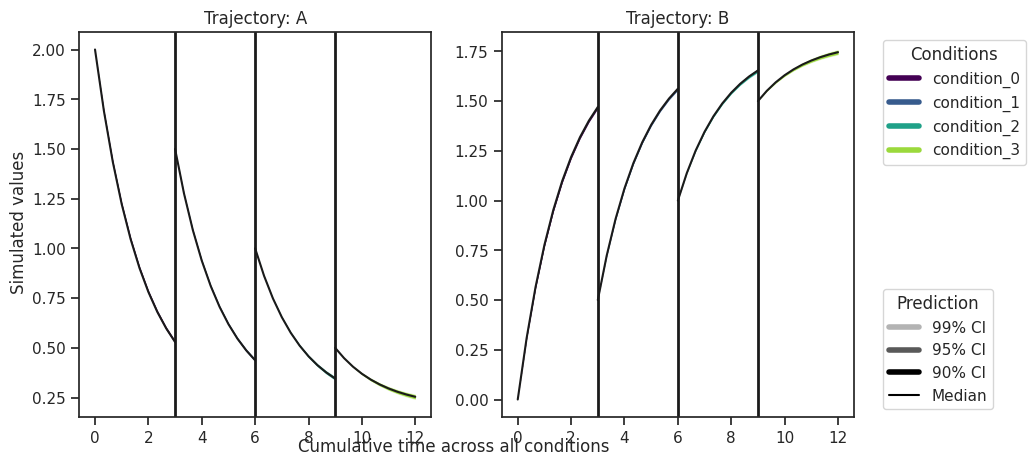

In [57]:
ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(10, 5),
    # labels={"A": "obs_A", "condition_0": "cond_0"},
    axis_label_padding=60,
    groupby=OUTPUT,
)

 ... (more hidden) ...


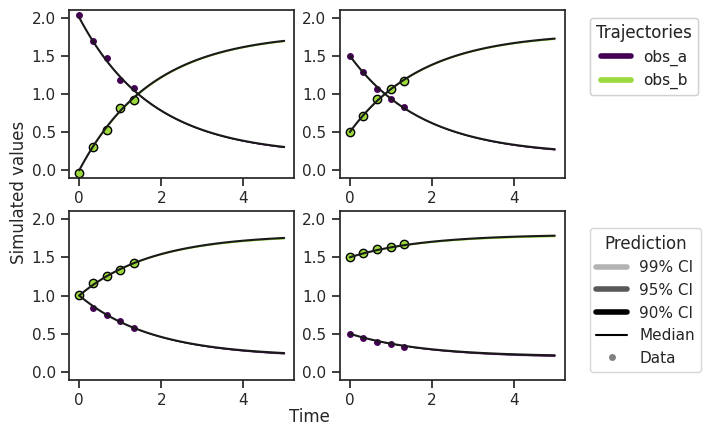

In [63]:
mdf = petab_problem.measurement_df
# Create a custom objective with new output timepoints.
timepoints = [np.linspace(0, 5, 100) for i in range(num_conditions)]
amici_objective_custom = amici_objective.set_custom_timepoints(
    timepoints=timepoints
)

# Create an observable predictor with the custom objective.
predictor_y_custom = AmiciPredictor(
    amici_objective_custom,
    post_processor=post_processor_y,
    output_ids=observable_ids,
    condition_ids=[edata.id for edata in amici_objective_custom.edatas],
)

# Predict then plot.
ensemble_prediction = ensemble.predict(
    predictor_y_custom, prediction_id=AMICI_Y, engine=engine
)

ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    groupby=CONDITION,
    measurement_df=mdf[mdf['time'] <= 1.5],
    
)
import matplotlib.pyplot as plt
ax[0][0].set_title('')
ax[1][0].set_title('')
ax[0][1].set_title('')
ax[1][1].set_title('')
ax[0][0].set_ylim([-0.1, 2.1])
ax[1][0].set_ylim([-0.1, 2.1])
ax[0][1].set_ylim([-0.1, 2.1])
ax[1][1].set_ylim([-0.1, 2.1])

plt.show()

In [59]:
petab_problem.measurement_df

,observableId,simulationConditionId,time,measurement
0,obs_a,c_1,0.000000,2.038581
1,obs_a,c_1,0.333333,1.691806
2,obs_a,c_1,0.666667,1.468857
3,obs_a,c_1,1.000000,1.183082
4,obs_a,c_1,1.333333,1.080257
...,...,...,...,...
75,obs_b,c_4,1.666667,1.696924
76,obs_b,c_4,2.000000,1.712099
77,obs_b,c_4,2.333333,1.707627
78,obs_b,c_4,2.666667,1.749923


Predictions are stored in `ensemble_prediction.prediction_summary`.

### Finding parameter point estimates
Commonly, as a first step, optimization is performed, in order to find good parameter point estimates.

In [ ]:
res = optimize.minimize(problem, n_starts=10, filename=None)

By passing the result object to the function, the previously found global optimum is used as starting point for the MCMC sampling.

In [ ]:
%%capture
res = sample.sample(
    problem, n_samples=1000, sampler=sampler, result=res, filename=None
)
elapsed_time = res.sample_result.time
print("Elapsed time: " + str(round(elapsed_time, 2)))

When the sampling is finished, we can analyse our results. pyPESTO provides functions to analyse both the sampling process as well as the obtained sampling result. Visualizing the traces e.g. allows to detect burn-in phases, or fine-tune hyperparameters. First, the parameter trajectories  can be visualized:

In [ ]:
ax = visualize.sampling_parameter_traces(
    res, use_problem_bounds=False, size=(12, 5)
)
ax[0][0].plot([0, 1000], np.log([k1_true, k1_true]), "k--")
ax[0][1].plot([0, 1000], np.log([k2_true, k2_true]), "k--")

By visual inspection one can see, that the chain is already converged from the start. This is already showing the benefit of initiating the chain at the optimal parameter vector. However, this may not be always the case.

In [ ]:
sample.geweke_test(result=res)
ax = visualize.sampling_parameter_traces(
    res, use_problem_bounds=False, size=(12, 5)
)
ax[0][0].plot([0, 1000], np.log([k1_true, k1_true]), "k--")
ax[0][1].plot([0, 1000], np.log([k2_true, k2_true]), "k--")

In [ ]:
sample.effective_sample_size(result=res)
ess = res.sample_result.effective_sample_size
print(
    f"Effective sample size per computation time: {round(ess/elapsed_time,2)}"
)

In [ ]:
percentiles = [99, 95, 90]
ax = visualize.sampling_parameter_cis(res, alpha=percentiles, size=(10, 5))

In [ ]:
# Create the ensemble with the MCMC chain from parallel tempering with the real temperature.
ensemble = Ensemble.from_sample(
    res,
    x_names=x_names,
    chain_slice=slice(None, None, 5),
    ensemble_type=EnsembleType.sample,
    lower_bound=res.problem.lb,
    upper_bound=res.problem.ub,
)

ensemble_prediction = ensemble.predict(
    predictor_y, prediction_id=AMICI_Y, engine=engine
)

In [ ]:
ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(10, 5),
    labels={"A": "obs_A", "condition_0": "cond_0"},
    axis_label_padding=60,
    groupby=CONDITION,
)

In [ ]:
ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(10, 5),
    # labels={"A": "obs_A", "condition_0": "cond_0"},
    axis_label_padding=60,
    groupby=OUTPUT,
    reverse_opacities=True,
)

Custom timepoints can also be specified, either for each condition
- `amici_objective.set_custom_timepoints(..., timepoints=...)`

or for all conditions
- `amici_objective.set_custom_timepoints(..., timepoints_global=...)`.

Plotting of measurement data (`petab_problem.measurement_df`) is also demonstrated here, which requires correct IDs in the `AmiciPredictor` that align with the observable and condition IDs in the measurement data.

In [ ]:

# Create a custom objective with new output timepoints.
timepoints = [np.linspace(0, 3, 100), np.linspace(0, 3, 100), np.linspace(0, 3, 10), np.linspace(0, 3, 10)]
amici_objective_custom = amici_objective.set_custom_timepoints(
    timepoints=timepoints
)

# Create an observable predictor with the custom objective.
predictor_y_custom = AmiciPredictor(
    amici_objective_custom,
    post_processor=post_processor_y,
    output_ids=observable_ids,
    condition_ids=[edata.id for edata in amici_objective_custom.edatas],
)

# Predict then plot.
ensemble_prediction = ensemble.predict(
    predictor_y_custom, prediction_id=AMICI_Y, engine=engine
)

ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    groupby=CONDITION,
    measurement_df=petab_problem.measurement_df,
    
)
import matplotlib.pyplot as plt
ax[0][0].set_title('')
ax[0][0].set_ylim([-0.1, 2.1])
ax[1][0].set_ylim([-0.1, 2.1])
ax[0][1].set_ylim([-0.1, 2.1])
plt.show()

In [30]:
mdf = petab_problem.measurement_df
mdf.head()

,observableId,simulationConditionId,time,measurement
0,obs_a,c_1,0.000000,1.996687
1,obs_a,c_1,0.333333,1.710996
2,obs_a,c_1,0.666667,1.426315
3,obs_a,c_1,1.000000,1.220508
4,obs_a,c_1,1.333333,1.073041


[<Axes: > <Axes: > <Axes: > <Axes: >]


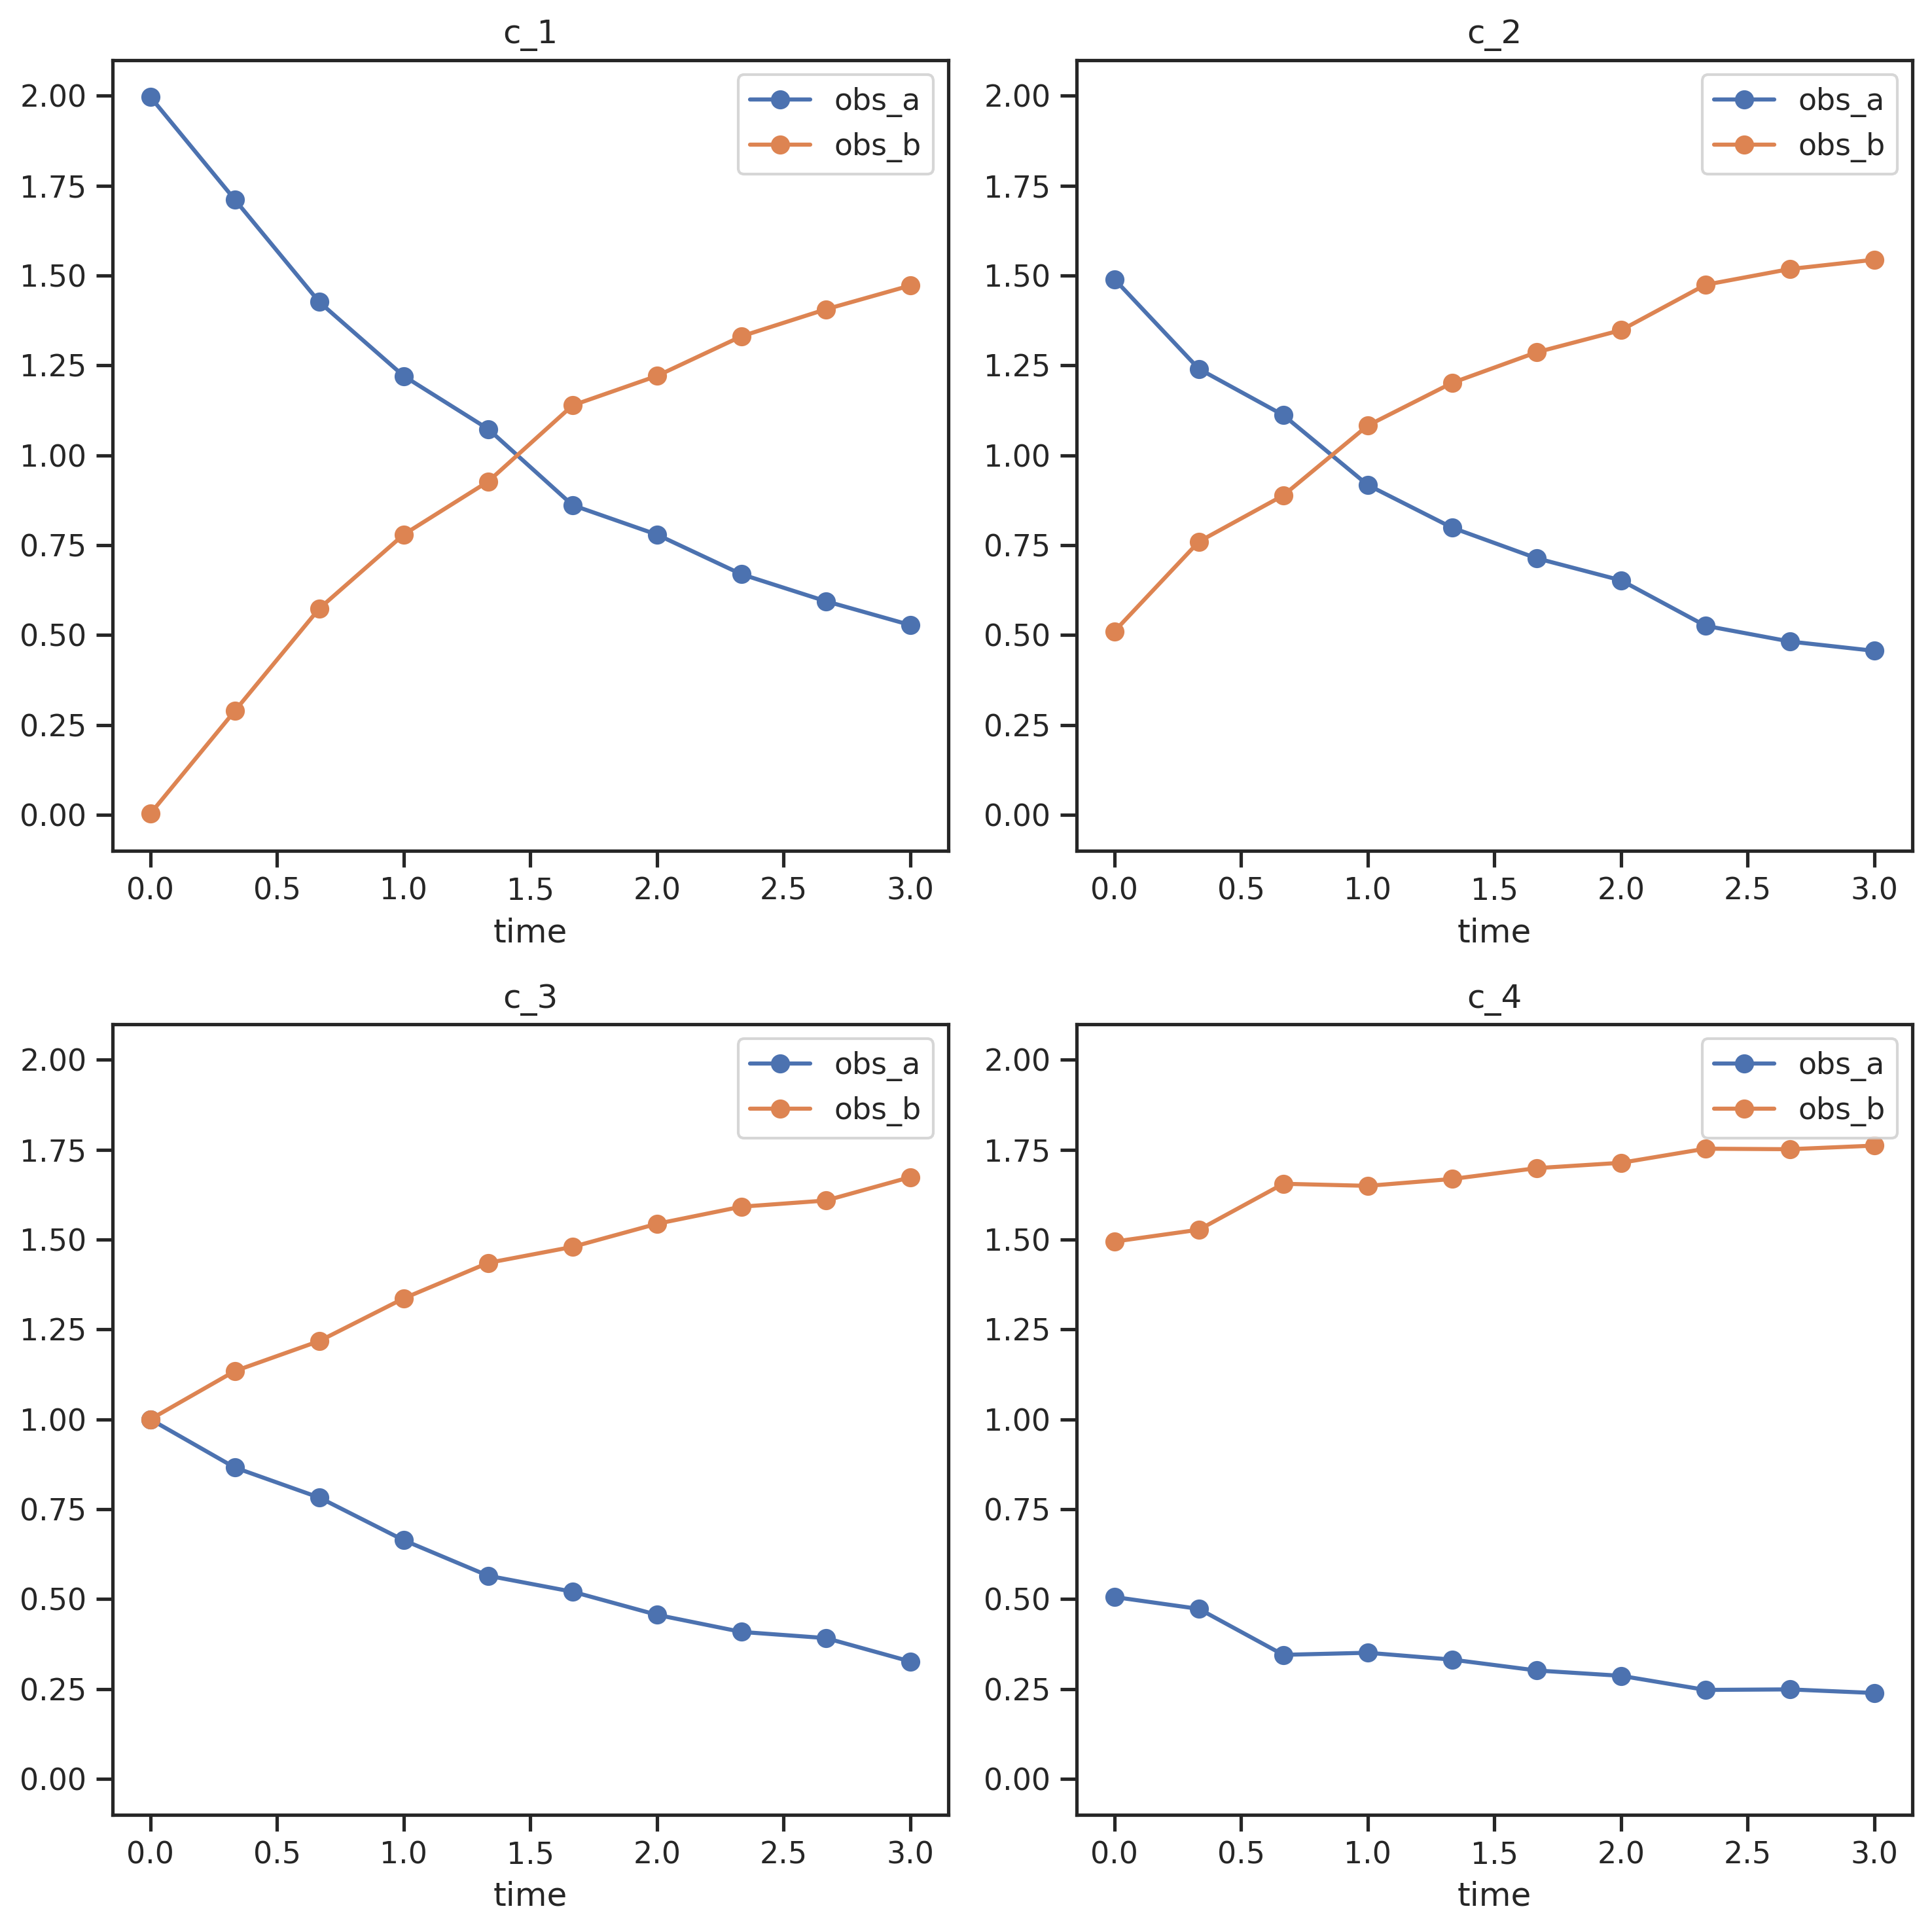

In [58]:
mdf[mdf['simulationConditionId'] == 'c_1']

observables = mdf['observableId'].unique()
conditions = mdf['simulationConditionId'].unique()
n_obs = len(observables)
n_conditions = len(conditions)
colors = []


fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=300)
axs = axs.flatten()
print(axs)
for i, condition in enumerate(conditions):
    for j, observable in enumerate(observables):
        data = mdf[(mdf['observableId'] == observable) & (mdf['simulationConditionId'] == condition)]
        axs[i].plot(data['time'], data['measurement'], 'o-', label=f'{observable}')
    axs[i].set_title(f'{condition}')
    axs[i].set_xlabel('time')
    axs[i].set_ylim([-0.1, 2.1])
    axs[i].legend()
plt.tight_layout()

In [35]:
mdf

,observableId,simulationConditionId,time,measurement
0,obs_a,c_1,0.000000,1.996687
1,obs_a,c_1,0.333333,1.710996
2,obs_a,c_1,0.666667,1.426315
3,obs_a,c_1,1.000000,1.220508
4,obs_a,c_1,1.333333,1.073041
...,...,...,...,...
75,obs_b,c_4,1.666667,1.698776
76,obs_b,c_4,2.000000,1.713642
77,obs_b,c_4,2.333333,1.752885
78,obs_b,c_4,2.666667,1.751427


In [ ]:
mdf = petab_problem.measurement_df
c0df = mdf[mdf["simulationConditionId"] == "c_1"]
c1df = mdf[mdf["simulationConditionId"] == "c_2"]

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(c0df["time"], c0df["measurement"], '-o', color='tab:blue')
ax[1].plot(c1df["time"], c1df["measurement"], '-o', color='tab:orange')
ax[0].set_xlabel('Time')
ax[1].set_xlabel('Time')
ax[0].legend(['c0'])
ax[1].legend(['c1'])
ax[0].set_ylabel('Exp data: Concentration of A (M)')
ax[1].set_ylabel('Exp data: Concentration of A (M)')

ax[0].set_title('Condition 0')
ax[1].set_title('Condition 1')
ax[0].set_ylim([0, 3.0])
ax[1].set_ylim([0, 3.0])